# PyYYC: Intro to Scikit-Learn
by matt whiteside, adapted from: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## Classification Part 2: Pipelining and Grid Search

Scikit-learn has formalized the process of training / testing to optimize the classification algorithm and algorithm parameters


In [ ]:
# There are lots of choices for algorithms
# Lets cover 3 common ones

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Define some functions and data to see features of different Classifiers

# Obtained from 
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, ensemble=False, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    
    if not ensemble:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, alpha=0.8, **params)
    else:
        # Choose alpha blend level with respect to the number
        # of estimators
        # that are in use (noting that AdaBoost can use fewer estimators
        # than its maximum if it achieves a good enough fit early on)
        estimator_alpha = 1.0 / len(clf.estimators_)
       
        for tree in clf.estimators_:
            Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            out = ax.contourf(xx, yy, Z, alpha=estimator_alpha, **params)
    
    return out


# import some data to play with
iris = datasets.load_iris()
# Take the first two features
X = iris.data[:, :2]
y = iris.target

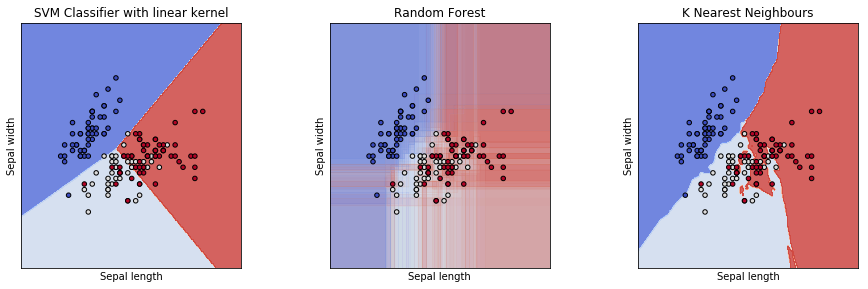

In [39]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = [ 
    LinearSVC(C=1.0),
    RandomForestClassifier(n_estimators=30),
    KNeighborsClassifier()
         ]
models = (clf.fit(X, y) for clf in models)

isensemble = [False, True, False]

# title for the plots
titles = ['SVM Classifier with linear kernel', 'Random Forest', 'K Nearest Neighbours']

# Set-up grid for plotting.
plt.rcParams["figure.figsize"] = (15,4.5)
fig, sub = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ens, ax in zip(models, titles, isensemble, sub.flatten()):
    plot_contours(ax, clf, xx, yy, ensemble=ens,
                  cmap=plt.cm.coolwarm)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

In [42]:
# Now lets get back to our dataset
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

categories = [
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey']

# But this time, lets make it a little harder and remove any meta data in message
# Don't want our machine learning method to train on message senders, etc
trainingset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=36, 
                                 remove=('headers', 'footers', 'quotes'))

testset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=36, 
                                 remove=('headers', 'footers', 'quotes'))


In [45]:
# Recall our steps:
# 1. Feature extraction (word occurence matrix)
# 2. Feature selection (min documents, TF-IDF)
# 3. Training (fit)
# 4. Evaluation (predict)

# There are many parameters each model in the that effect performance. These are called hyper-parameters
# The machine learning way:
# Exhaustively search many different combinations
# When trying lots of different combinations, pipelines help chain together training steps

svmpipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LinearSVC())
])

svmpipe.fit(trainingset.data, trainingset.target)
predicted = svmpipe.predict(testset.data)
print(classification_report(testset.target, predicted, target_names=testset.target_names))
# Three steps in 1!!

                    precision    recall  f1-score   support

         rec.autos       0.77      0.89      0.82       396
   rec.motorcycles       0.87      0.81      0.84       398
rec.sport.baseball       0.86      0.82      0.84       397
  rec.sport.hockey       0.90      0.86      0.88       399

       avg / total       0.85      0.85      0.85      1590



In [81]:
# Now lets explore other hyper-parameters using GridSearch
svmparameters = {'vectorizer__max_df': [500,1000],
    'classifier__loss': ('hinge','squared_hinge'),
    'classifier__C': (0.1,0.5,1.0)
}

svmgrid = GridSearchCV(svmpipe, svmparameters, n_jobs=8)

svmgrid.fit(trainingset.data, trainingset.target)
predicted = svmgrid.predict(testset.data)
print(classification_report(testset.target, predicted, target_names=testset.target_names))

                    precision    recall  f1-score   support

         rec.autos       0.87      0.82      0.84       396
   rec.motorcycles       0.87      0.83      0.85       398
rec.sport.baseball       0.79      0.89      0.84       397
  rec.sport.hockey       0.91      0.88      0.89       399

       avg / total       0.86      0.86      0.86      1590



In [91]:
svmgrid.best_params_

# How does Grid Search determine the optimum hyper-parameters?
# Through a cross-validation search

# The training data is split into two random parts: training and validation sets
# For each split, each model is fitted and the accuracy is measured
# This process is repeated a number of times and the accuracies are averaged
# Top performing model is returned

{'classifier__C': 0.5, 'classifier__loss': 'hinge', 'vectorizer__max_df': 500}

In [123]:
# Random Forest
rfpipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier())
])

rfparameters = {'vectorizer__max_df': (100,500),
    'classifier__n_estimators': (30,300),
    'classifier__max_depth': (5,15,30)
}

rfgrid = GridSearchCV(rfpipe, rfparameters, n_jobs=8)

rfgrid.fit(trainingset.data, trainingset.target)
predicted = rfgrid.predict(testset.data)
print(classification_report(testset.target, predicted, target_names=testset.target_names))

                    precision    recall  f1-score   support

         rec.autos       0.64      0.90      0.75       396
   rec.motorcycles       0.78      0.72      0.75       398
rec.sport.baseball       0.92      0.77      0.84       397
  rec.sport.hockey       0.96      0.81      0.88       399

       avg / total       0.83      0.80      0.80      1590



In [124]:
rfgrid.best_params_

{'classifier__max_depth': 15,
 'classifier__n_estimators': 300,
 'vectorizer__max_df': 500}

In [117]:
# K Nearest Neighbours
knnpipe = Pipeline([
    ('vectorizer', CountVectorizer(max_df=500)),
    ('tfidf', TfidfTransformer()),
    ('classifier', KNeighborsClassifier())
])

knnparameters = {
    'vectorizer__min_df': (10,100),
    'classifier__n_neighbors': (3,5),
    'classifier__weights': ('uniform', 'distance')
}

knngrid = GridSearchCV(knnpipe, knnparameters, n_jobs=8)

knngrid.fit(trainingset.data, trainingset.target)
predicted = knngrid.predict(testset.data)
print(classification_report(testset.target, predicted, target_names=testset.target_names))

                    precision    recall  f1-score   support

         rec.autos       0.59      0.22      0.32       396
   rec.motorcycles       0.53      0.24      0.33       398
rec.sport.baseball       0.55      0.21      0.30       397
  rec.sport.hockey       0.30      0.84      0.44       399

       avg / total       0.49      0.38      0.35      1590



In [114]:
knngrid.best_params_

{'classifier__n_neighbors': 3,
 'classifier__weights': 'distance',
 'vectorizer__min_df': 100}

In [154]:
# Ngrams
# consecutive pairs or sequences of words
ngram_vectorizer = CountVectorizer(ngram_range=(1,2))
test_messages = ['This is really NOT cool', 'Maybe its not bad']
word_counts = ngram_vectorizer.fit_transform(test_messages)
print(ngram_vectorizer.get_feature_names())

['bad', 'cool', 'is', 'is really', 'its', 'its not', 'maybe', 'maybe its', 'not', 'not bad', 'not cool', 'really', 'really not', 'this', 'this is']


In [ ]:
# Do N-grams help?
svmpipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LinearSVC(C=0.5,loss='hinge'))
])

svmparameters = {'vectorizer__ngram_range': [(1,1),(1,2),(2,3)]}

svmgrid = GridSearchCV(svmpipe, svmparameters, n_jobs=8)

svmgrid.fit(trainingset.data, trainingset.target)
predicted = svmgrid.predict(testset.data)
print(classification_report(testset.target, predicted, target_names=testset.target_names))

In [150]:
sgdgrid.best_params_

{'classifier__penalty': 'l2',
 'tfidf__use_idf': True,
 'vectorizer__ngram_range': (1, 1)}

In [ ]:
# Checkout https://github.com/hyperopt/hyperopt-sklearn. 
# Provides search algorithms to more quickly arrive at optimu